<a href="https://colab.research.google.com/github/rsadaphule/jhu-cv/blob/main/v2_JHU_CV_HW_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Write a python code for a conditional GAN (cGAN) architecture using the code in reference [1] and MNIST dataset to perform the following mappings (i.e., odd digit to even digit image image):


**Step 1: Import Libraries**

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt


**Step 2: Define the Dataset
We'll modify the MNIST dataset to return the next odd digit for an even input digit.**

In [30]:
class CustomMNIST(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        # Map even labels to the next odd labels
        if label % 2 == 0 and label != 8:
            label += 1
        elif label == 8:  # Special case for 8 => 9
            label = 9
        if self.transform:
            img = self.transform(img)
        return img, label


**Step 3: Load and Preprocess the MNIST Dataset**

In [31]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Example transform that expects a PIL Image
    transforms.Normalize((0.5,), (0.5,)),  # Normalizes the tensor
    transforms.ToTensor(),  # Converts PIL Image to Tensor

])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Wrap the MNIST dataset with CustomMNIST
#train_dataset = CustomMNIST(mnist_train, transform=transform)
#test_dataset = CustomMNIST(mnist_test, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)


**Step 4: Define the Generator and Discriminator Networks**

In [32]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(10, 10)
        self.init_size = 7  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(110, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(10, 28*28)

        self.model = nn.Sequential(
            nn.Linear(1*28*28 + 28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity


In [33]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the correct sequence of transformations
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Example transform that expects a PIL Image
    transforms.ToTensor(),  # Converts PIL Image to Tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalizes the tensor
])

# Load the dataset with the defined transformations
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Test loading a batch
for imgs, labels in train_loader:
    print(imgs.shape, labels.shape)
    break  # Break after the first batch to just test


torch.Size([64, 1, 28, 28]) torch.Size([64])


**Step 5: Training Loop**

In [ ]:
from torchvision.utils import save_image
import os


# Initialize lists for storing losses
g_losses = []
d_losses = []

# Hyperparameters
epochs = 200
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_classes = 10
latent_dim = 100
sample_interval = 400

# Create output image directory
os.makedirs("images", exist_ok=True)

# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))



# Learning rate schedulers
scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=30, gamma=0.1)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=30, gamma=0.1)


# Training
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(train_loader):

        # Adapting labels for even to odd mapping
        mapped_labels = (labels + 1) % 10
        mapped_labels[labels % 2 != 0] = labels[labels % 2 != 0]  # Keep odd labels unchanged

        # Move tensors to the appropriate device
        real_imgs = imgs.cuda() if torch.cuda.is_available() else imgs
        labels = labels.cuda() if torch.cuda.is_available() else labels
        mapped_labels = mapped_labels.cuda() if torch.cuda.is_available() else mapped_labels
        valid = torch.ones(imgs.size(0), 1, requires_grad=False).cuda() if torch.cuda.is_available() else torch.ones(imgs.size(0), 1, requires_grad=False)
        fake = torch.zeros(imgs.size(0), 1, requires_grad=False).cuda() if torch.cuda.is_available() else torch.zeros(imgs.size(0), 1, requires_grad=False)

        # ---------------------
        #  Train Generator
        # ---------------------
        optimizer_G.zero_grad()

        # Generate a batch of images
        z = torch.randn(imgs.shape[0], latent_dim).cuda() if torch.cuda.is_available() else torch.randn(imgs.shape[0], latent_dim)
        gen_imgs = generator(z, mapped_labels)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs, mapped_labels), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), mapped_labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # Save Losses for plotting later
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
        # ---------------------
        #  Log Progress
        # ---------------------
        print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

        batches_done = epoch * len(train_loader) + i
        if batches_done % sample_interval == 0:
            save_image(gen_imgs.data[:25], f"images/{batches_done}.png", nrow=5, normalize=True)

    # Update the learning rate
    scheduler_G.step()
    scheduler_D.step()

    # Save model checkpoints
    if epoch % 10 == 0:
        torch.save({
            'epoch': epoch,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
            'scheduler_G_state_dict': scheduler_G.state_dict(),
            'scheduler_D_state_dict': scheduler_D.state_dict(),
        }, f"checkpoint_epoch_{epoch}.pth")


Streaming output truncated to the last 5000 lines.
[Epoch 187/200] [Batch 836/938] [D loss: 0.5294620394706726] [G loss: 1.111051321029663]
[Epoch 187/200] [Batch 837/938] [D loss: 0.5023745894432068] [G loss: 1.1119606494903564]
[Epoch 187/200] [Batch 838/938] [D loss: 0.4946213662624359] [G loss: 1.146350383758545]
[Epoch 187/200] [Batch 839/938] [D loss: 0.44949162006378174] [G loss: 1.1147434711456299]
[Epoch 187/200] [Batch 840/938] [D loss: 0.45623260736465454] [G loss: 1.0973825454711914]
[Epoch 187/200] [Batch 841/938] [D loss: 0.470370888710022] [G loss: 1.1339008808135986]
[Epoch 187/200] [Batch 842/938] [D loss: 0.4590776264667511] [G loss: 1.119734525680542]
[Epoch 187/200] [Batch 843/938] [D loss: 0.4696253538131714] [G loss: 1.1375216245651245]
[Epoch 187/200] [Batch 844/938] [D loss: 0.5253046154975891] [G loss: 1.13157320022583]
[Epoch 187/200] [Batch 845/938] [D loss: 0.45293524861335754] [G loss: 1.1191054582595825]
[Epoch 187/200] [Batch 846/938] [D loss: 0.508209943

**Step 6: Visualization and Evaluation**

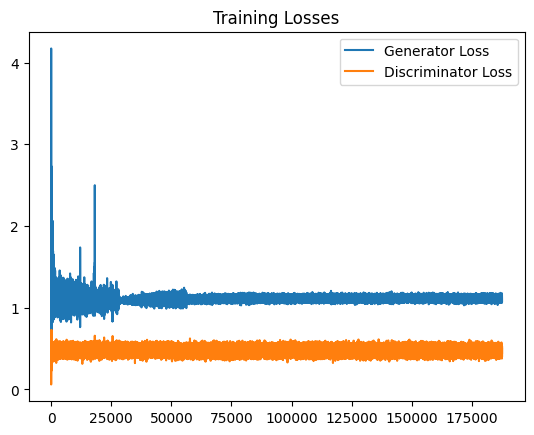

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Assuming you have saved loss values in two lists: g_losses and d_losses
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.title("Training Losses")
plt.legend()
plt.show()

**Step 7: Display inference for sample images**

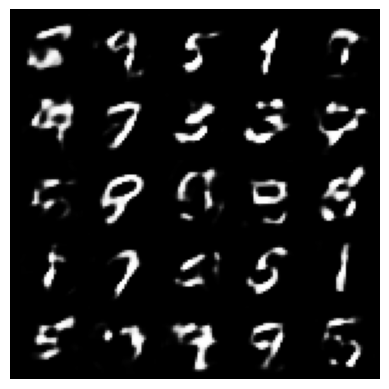

In [38]:
some_batch_number = 1200
img = mpimg.imread(f'images/{some_batch_number}.png')  # Specify the correct file path
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()